In [2]:
import sys
# for loss functions
#sys.path.insert(0, "/home/projects/ku_00017/people/simpol/scripts/conflictNet/src/utils")
sys.path.insert(0, "/home/simon/Documents/scripts/conflictNet/src/utils")

import numpy as np
import torch
from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss


import torch.nn as nn
import torch.nn.functional as F


from torch.autograd import Variable

from shrinkage import ShrinkageLoss
from stable_balanced_focal_class import stableBalancedFocalLossClass
from focal_june import FocalLoss_new

from shringkage_june import ShrinkageLoss_new
from focal_june import FocalLoss_new


# https://d2l.ai/chapter_recurrent-modern/gru.html

import matplotlib.pyplot as plt




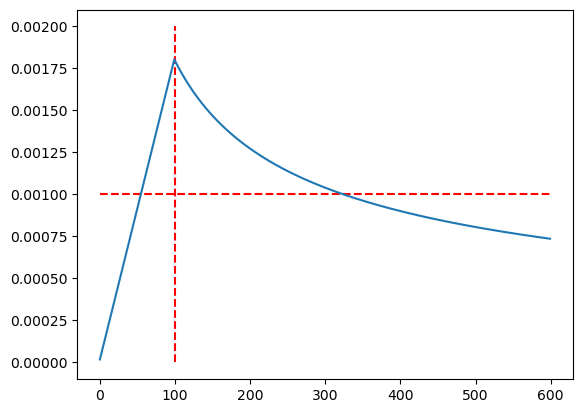

In [60]:
# attentions is all ... 

d = 32*32*3 
step_num = 600
warmup_steps = 100

lr_list = []

for step_num in range(1, step_num+1):

    lr = d**(-0.5) * min(step_num**(-0.5), step_num*warmup_steps**(-1.5))
    lr_list.append(lr)

plt.vlines(warmup_steps, 0, 0.002, colors='r', linestyles='dashed')
plt.hlines(0.001, 0, step_num, colors='r', linestyles='dashed')
plt.plot(lr_list)
plt.show()

In [12]:
criterion_p = nn.BCELoss()
criterion_l = nn.BCEWithLogitsLoss()

criterion_focal01 = stableBalancedFocalLossClass(gamma=0, alpha=0.5) # gamma=0 no weights, alpha=0.5 even weights
criterion_focal02 = FocalLoss_new(gamma=1, alpha=0.5) # gamma=0 no weights, alpha=0.5 even weights

shringkage = ShrinkageLoss_new()

In [3]:
# Generate binary ground truth labels (0 or 1) with thousands of entries
num_samples = 100000
y = torch.randint(0, 2, (num_samples,), dtype=torch.float32)

# Generate predicted logits or probabilities with the same shape as y
# For testing purposes, I'm using random values here.
# You can replace this with your actual predicted logits or probabilities.
y_hat_logits = torch.randn((num_samples,), dtype=torch.float32)

# Optionally, you can normalize logits to probabilities using sigmoid for binary classification
y_hat_probs = torch.sigmoid(y_hat_logits)



In [11]:
print(criterion_p(y_hat_probs, y))
print(criterion_l(y_hat_logits, y))

print(criterion_focal01(y_hat_logits, y))
print(criterion_focal02(y_hat_logits, y))



tensor(0.7982)
tensor(0.7982)
tensor(nan)
tensor(3140.0649)


In [5]:
# Generate ground truth value (0 to 9) with thousands of entries
num_samples = 100000
y = torch.randint(0, 10, (num_samples,), dtype=torch.float32)

y_hat = F.relu(torch.randn(num_samples, dtype=torch.float32) + 5 * 2 ) # 5 is the mean, 2 is the std

print(shringkage(y, y_hat))

tensor(39.5226)


In [ ]:
X = np.random.randint(1,21,[5,5,5])
X_tensor = torch.from_numpy(X)



In [ ]:
X = np.random.randint(1,21,[5,5,5])
X_tensor = torch.tensor(X)

In [ ]:
X_tensor = torch.tensor(X)

In [ ]:
X_tensor

In [ ]:
criterion_reg = nn.MSELoss()
criterion_class = nn.BCELoss()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(
            self,
            weight=None,
            gamma=2.0,
            reduction='mean'
    ):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = torch.sigmoid(input_tensor)
        prob = torch.exp(log_prob)
        
        term = ((1.0 - prob) ** self.gamma) * log_prob
        return F.nll_loss(term, target_tensor)
        
        #return F.nll_loss(term, target_tensor, weight=self.weight, reduction=self.reduction)
        

In [ ]:
class FocalLoss01(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss01, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.contiguous().view(input.size(0), input.size(1), -1)
            input = input.transpose(1,2)
            input = input.contiguous().view(-1, input.size(2)).squeeze()
        if target.dim()==4:
            target = target.contiguous().view(target.size(0), target.size(1), -1)
            target = target.transpose(1,2)
            target = target.contiguous().view(-1, target.size(2)).squeeze()
        elif target.dim()==3:
            target = target.view(-1)
        else:
            target = target.view(-1, 1)

        # compute the negative likelyhood
        weight = Variable(self.weight)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss02(nn.Module):

    def __init__(self, gamma=0, weight=None, size_average=True):
        super(FocalLoss02, self).__init__()

        self.gamma = gamma
        self.weight = weight
        self.size_average = size_average

    def forward(self, input, target):
        # if input.dim()>2:
        #     input = input.contiguous().view(input.size(0), input.size(1), -1)
        #     input = input.transpose(1,2)
        #     input = input.contiguous().view(-1, input.size(2)).squeeze()
        # if target.dim()==4:
        #     target = target.contiguous().view(target.size(0), target.size(1), -1)
        #     target = target.transpose(1,2)
        #     target = target.contiguous().view(-1, target.size(2)).squeeze()
        # elif target.dim()==3:
        #     target = target.view(-1)
        # else:
        #     target = target.view(-1, 1)

        input, target = input.unsqueeze(0), target.unsqueeze(0)

        # compute.unsqueeze(0)F.cross_entropy(input, target)
        logpt = -F.cross_entropy(input, target)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1-pt)**self.gamma) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss03(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss03, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)

        # compute.unsqueeze(0)F.cross_entropy(input, target)
        p = 1/(1+np.exp(-input))
        loss = -( self.alpha*target + (1-self.alpha)*(1-target) ) * (( 1 - ( target*p + (1-target)*(1-p)) )**self.gamma) * ( target*np.log(p)+(1-target)*np.log(1-p) )

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss04(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss04, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        
        input, target = input.unsqueeze(0), target.unsqueeze(0)

        loss = -(target * np.log(input) + (1-target) * np.log(1-input)) #BCE

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLoss05(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss05, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        logpt = (target * np.log(input) + (1-target) * np.log(1-input))
        loss = -self.alpha * ((1-np.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
# BEST!!!

class FocalLoss05(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss05, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        logpt = (target * np.log(input) + (1-target) * np.log(1-input))
        loss = -self.alpha * ((1-np.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class FocalLossClass(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLossClass, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)

        logpt = (target * torch.log(input) + (1-target) * torch.log(1-input))
        loss = -self.alpha * ((1-torch.exp(logpt))**self.gamma) * logpt # for gamma = 0 and alpha = 1 we get the BCELoss

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
# #WORKS!
# class BalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(BalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)
#         input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)

#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))

#         #pos = ( (1-input)**self.gamma * torch.log(input))
#         #neg = ( (input)**self.gamma *  torch.log(1-input))

#         loss = -(pos * target + neg * (1-target))

#         # averaging (or not) loss
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
# class BalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(BalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)
        

#         #for logits
#         # pos = (-self.alpha * (1-F.sigmoid(input))**self.gamma * F.logsigmoid(input))
#         # neg = (-(1-self.alpha) * (-F.sigmoid(input))**self.gamma *  F.logsigmoid(1-input))
#         # loss = (pos * target + neg * (1-target))

#         # for probs
#         input = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)
#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))
#         loss = (pos * target + neg * (1-target))

#         # averaging (or not) loss
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
# class stableBalancedFocalLossClass(nn.Module):

#     def __init__(self, gamma=0, alpha=0.5, size_average=True):
#         super(stableBalancedFocalLossClass, self).__init__()

#         self.gamma = gamma
#         self.alpha = alpha
#         self.size_average = size_average

#     def forward(self, input, target):

#         input, target = input.unsqueeze(0), target.unsqueeze(0)

#         # fo   r probs
#         min_ind = torch.exp(torch.tensor(-100)) # almost 0
#         max_ind = torch.tensor(1.0)- torch.exp(torch.tensor(-10)) # almost 1
#         input = torch.clamp(input, min = min_ind, max = max_ind) # so we do not log(0)

#         pos = (-self.alpha * (1-input)**self.gamma * torch.log(input))
#         neg = (-(1-self.alpha) * (1-1-input)**self.gamma *  torch.log(1-input))
#         loss = (pos * target + neg * (1-target))

#         # Seem pytorch have something like this..
#         if loss.mean() >= max_ind:
#             floor = 10
#         else:
#             floor = 1

#         loss =  loss * 2 * floor # *2 is just a constant to make it more like BCE

#         # averaging (or not) lossinput = torch.clamp(input, min = torch.exp(torch.tensor(-100))) # so we do not log(0)
        
#         if self.size_average:
#             return loss.mean()
#         else:
#             return loss.sum()

In [ ]:
def shannon_entropy(p):
    return (p * np.log(1/p)).sum()

def cross_entropy(p, q):
    return -(p * np.log(q)).sum() # same as (p * np.log(1/q)).sum() 

In [ ]:
class BalancedFocalLossClass(nn.Module):

    def __init__(self, gamma=0, alpha=0.5, size_average=True):
        super(BalancedFocalLossClass, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        
        # Numerical stabilityt pytorhc trick.
        log_input = torch.clamp(torch.log(input), -100, 100)
        log_input_rev = torch.clamp(torch.log(1-input), -100, 100)

        # for probs
        pos = (-self.alpha * (1-input)**self.gamma * log_input)
        neg = (-(1-self.alpha) * (1-1-input)**self.gamma * log_input_rev)
        
        loss = (pos * target + neg * (1-target))

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_class = nn.BCELoss()

x1 = torch.rand([ 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
# criterion_focal01 = FocalLoss01(gamma=1)
# criterion_focal02 = FocalLoss02(gamma=1, size_average=False)
# criterion_focal03 = FocalLoss03(gamma=1, alpha = 1, size_average=True)

# criterion_focal04 = FocalLoss04(gamma=0)
# criterion_focal05 = FocalLoss05()

#criterion_focal06 = FocalLossClass()
criterion_focal07 = BalancedFocalLossClass(gamma=2, alpha=0.05)
# criterion_focal07 = stableBalancedFocalLossClass(gamma=0, alpha=0.5)


# print(criterion_focal01(x1.unsqueeze(0), x1_b.unsqueeze(0)))
# print(criterion_focal02(x1, x1_b))
# print(criterion_focal03(x1, x1_b))


# print(criterion_focal04(x1, x1_b))

# print(criterion_focal05(x1, x1_b))

#print(criterion_focal06(x1, x1_b))

print(criterion_focal07(x1, x1_b)) 


print(criterion_class(x1, x1_b))


In [ ]:
criterion_focal07 = BalancedFocalLossClass(gamma=0, alpha=0.5)

print(criterion_focal07(x1, x1_b)) 
print(criterion_class(x1, x1_b))

In [ ]:
x1 = torch.rand([ 3 ,100, 100]) 

x2 = torch.zeros([ 3 ,100, 100]) + torch.tensor(1.0) - torch.exp(torch.tensor(0))

x1_b = (x1 > 0.5)*1.0 


print(criterion_focal07(x2, x1_b)*2) 
print(criterion_class(x2, x1_b))

In [ ]:
x2

In [ ]:
x1 = torch.rand([ 3 ,100, 100]) 

x2 = torch.zeros([ 3 ,100, 100]) + torch.tensor(1.0) - torch.exp(torch.tensor(-12))

x1_b = (x1 > 0.5)*1.0 

if x2.mean() > torch.tensor(1.0) - torch.exp(torch.tensor(-15)):
    floor = 10
else:
    floor = 1

print(criterion_focal07(x2, x1_b) * floor) 
print(criterion_class(x2, x1_b))

In [ ]:
print(criterion_class)

In [ ]:
criterion_focal_class01 = BalancedFocalLossClass(gamma=0.0, alpha=0.75)
criterion_focal_class02 = BalancedFocalLossClass(gamma=2.0, alpha=0.25)
criterion_focal_class03 = BalancedFocalLossClass(gamma=5.0, alpha=0.25)

In [ ]:
print(f'focal, gamma = 0, alpha = 1 : \t {criterion_focal_class01(x1, x1_b)}')
print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_class02(x1, x1_b)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_class03(x1, x1_b)}')

In [ ]:
F.logsigmoid(torch.tensor(.00))

In [ ]:
# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32)

# candidates
ZT = torch.zeros([ 3 ,100, 100])
RT = torch.rand([ 3 ,100, 100]) 

# the loss must priorities 0T over ZT

In [ ]:
criterion = BalancedFocalLossClass(gamma=2, alpha=0.95)


print(criterion(ZT, IT)) 
print(criterion(RT, IT)) 

In [ ]:
class FocalLoss_reg(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss_reg, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        input = torch.clamp(input, min = np.exp(-100)) # so we do not log(0)

        mse = (target - input)**2

        loss = self.alpha * ((1-np.exp(mse))**self.gamma) * mse # for gamma = 0 and alpha = 1 we get the mse

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_reg = nn.MSELoss()

x1 = torch.rand([ 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
criterion_focal_reg01 = FocalLoss_reg(gamma=0)
criterion_focal_reg02 = FocalLoss_reg(gamma=1)
criterion_focal_reg03 = FocalLoss_reg(gamma=2)

In [ ]:
# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32)

# candidates
ZT = torch.zeros([ 3 ,100, 100])
OT = torch.zeros([ 3 ,100, 100]) + 1

# the loss must priorities 0T over ZT

In [ ]:
print(f'MSE: \t\t\t\t {criterion_reg(ZT, IT)}')
print(f'focal, gamma = 0, alpha = 1 : \t {criterion_focal_reg01(ZT, IT)}')
print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_reg02(ZT, IT)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_reg03(ZT, IT)}')


print('\n')

print(f'focal, gamma = 1, alpha = 1 : \t {criterion_focal_reg01(OT, IT)}')
print(f'focal, gamma = 2, alpha = 1 : \t {criterion_focal_reg02(OT, IT)}')
print(f'focal, gamma = 3, alpha = 1 : \t {criterion_focal_reg03(OT, IT)}')



In [ ]:
def MSE(input, target):
    loss = (target - input)**2
    return loss.mean()

In [ ]:
def MSE(input, target):
    se = target - input
    lse = np.exp(se)  #torch.clamp(se, min = np.exp(-100)))
    mlse = lse.mean()

    return mlse

    # return - np.log(loss.mean())

In [ ]:
noise = torch.rand([ 3 ,100, 100]) * 10

# targer
IT = torch.tensor(np.stack([np.identity(100), np.identity(100),  np.identity(100)]), dtype= torch.float32) * noise

# candidates
ZT = torch.zeros([ 3 ,100, 100])
OT = (torch.zeros([ 3 ,100, 100]) + 1 ) * noise

# the loss must priorities 0T over ZT

In [ ]:
print(MSE(ZT, IT))
print(MSE(OT, IT))

In [ ]:
OT.min()

In [ ]:
class FocalLoss_reg(nn.Module):

    def __init__(self, gamma=0, alpha=1, size_average=True):
        super(FocalLoss_reg, self).__init__()

        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0)
        #input = torch.clamp(input, min = np.exp(-100)) # could do this for no negatives???

        error = target - input
        exp_error = np.exp(error)  #torch.clamp(se, min = np.exp(-100)))
        loss = exp_error.mean()

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
class ShrinkageLoss(nn.Module):

    def __init__(self, a=10, c=0.2, size_average=True):
        super(ShrinkageLoss, self).__init__()

        self.a = a
        self.c = c
        self.size_average = size_average

    def forward(self, input, target):

        input, target = input.unsqueeze(0), target.unsqueeze(0) 

        l = torch.abs(target - input)     #F.l1_loss(input, target)

        loss = (l**2)/(1 + torch.exp(self.a*(self.c-l)))

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

In [ ]:
criterion_focal_reg = ShrinkageLoss(a=10, c=0.2)

In [ ]:
criterion_focal_reg = ShrinkageLoss(a=1, c=12)

print(criterion_focal_reg(ZT, IT))
print(criterion_focal_reg(OT, IT))


In [ ]:
x1_b.dtype

In [ ]:
IT

In [ ]:
shannon_entropy(x1)

In [ ]:
cross_entropy(x1_b, x1)

In [ ]:
cross_entropy(x1_b, x1)

In [ ]:
F.cross_entropy( x1_b, x1)

In [ ]:
F.cross_entropy?

In [ ]:
-(x1_b * np.log(x1)).mean()

In [ ]:
(x1_b * (np.log(1/x1))).mean()

In [ ]:
print(criterion_focal02(x1, x1_b))
print(criterion_class(x1, x1_b))


In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [ ]:
t = 3

if t == 1 or t == 0:
    print('cool')

In [ ]:
cr.

In [ ]:
cr = RMSLELoss()
print(f'sgoairb: {cr}\n..................')

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
x1 = torch.rand([3,100, 100])
x1_b = (x1 > 0.5)*1.0 

In [ ]:
criterion_focal = FocalLoss2d()

In [ ]:
print(criterion_focal)

In [ ]:
criterion_focal(x1.unsqueeze(0), x1_b.unsqueeze(0))

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])
x1_b = (x1 > 0.5)*1.0 

sigmoid_focal_loss(x1, x1_b, reduction= 'mean')

In [ ]:
x1 = torch.rand([1, 3 ,100, 100])#.type(torch.LongTensor)
x1_b = (x1 > 0.5)*1.0 

criterion_focal(x1.reshape(-1), x1_b.reshape(-1).type(torch.LongTensor))

In [ ]:
x1 = torch.randn([1, 3 ,100, 100]).float()

#x1 = torch.randn([1, 3 ,100, 100]).float()
x2 = torch.randn([1, 3 ,100, 100]).float()

x3 = torch.randn([1, 3 ,100, 100]).float()
x4 = torch.randn([1, 3 ,100, 100]).float()

In [ ]:
# x1_ = x1.reshape(-1)
# x2_ = x2.reshape(-1)

# mask = x1_ > 0

# x1_[mask].shape

# criterion_reg(x1_, x2_)


In [ ]:
type(losses_list) == list

In [ ]:
losses_list = []

for i in range(3):

    x1_ = x1[:,i,:,:].reshape(-1)
    x2_ = x2[:,i,:,:].reshape(-1)
    mask = (x3[:,i,:,:].reshape(-1) > 0.0001) | (x4[:,i,:,:].reshape(-1) > 0.0001)

    losses_list.append(criterion_reg(x1_[mask], x2_[mask]))


In [ ]:
losses_list

In [ ]:
for i in range(3):
    losses_list.append(criterion_class(t1_pred_class[:,i,:,:], t1_binary[:,i,:,:]))

In [ ]:
losses_list = []

for i in range(3):
    print(i)
    losses_list.append(torch.tensor(1.0))

for i in range(3):
    losses_list.append(torch.tensor(2.0))


In [ ]:
losses = torch.stack(losses_list)

In [ ]:
losses[:3].sum()

In [ ]:
losses[-3:].sum()


In [ ]:
for i in range(6):
    print(losses[i])

In [ ]:
hidden_channels = 32
D = 16 


X = torch.rand(1, 3, D, D)
H = torch.rand(1, hidden_channels, D, D)

In [ ]:
H+X

In [ ]:
c1 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c2 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

c3 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c4 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

c5 = torch.nn.Conv2d(32,32, 3, padding= 'same')
c6 = torch.nn.Conv2d(32,32, 3, padding= 'same', bias = False)

In [ ]:
Z = torch.sigmoid(c1(X) + c2(H))

R = torch.sigmoid(c3(X) + c4(H))

H_tilde = torch.tanh(c5(X) + c6(torch.mul(R,H)))

H = torch.mul(torch.mul(Z,H) + (1 - Z), H_tilde)

In [ ]:
H.shape

In [ ]:
vol = np.zeros([1,48,3,180,180])
tens  =torch.tensor(vol)

torch.stack((tens,tens)).shape

In [ ]:
vol = np.zeros([1,48,3,180,180])

In [ ]:
vol[:,:,0,:,:] = 1
vol[:,:,1,:,:] = 2
vol[:,:,2,:,:] = 3


In [ ]:
print(vol.shape)
print(vol[:,:,0,:,:].mean())
print(vol[:,:,1,:,:].mean())
print(vol[:,:,2,:,:].mean())

In [ ]:
N = vol.shape[0] # batch size. Always 1
C = vol.shape[1] # months
D = vol.shape[2] # features
H = vol.shape[3] # height
W = vol.shape[4] # width

vol2 = vol.reshape(N, C*D, H, W)
print(vol2.shape)

In [ ]:
# transformer = transforms.Compose([transforms.RandomRotation((0,360)), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])
transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])

In [ ]:
#data augmentation (can be turned of for final experiments)        
vol2 = transformer(torch.tensor(vol2)) # rotations and flips # skip for now... '''''''''''''''''''''''''''''''''''''''''''''''''''''' bug only take 4 dims.. could just squezze the batrhc dom and then give it again afterwards?#train_tensor = train_tensor.reshape(N, C, D, H, W)

In [ ]:
vol3 = vol2.reshape(N,C,D,H,W)
print(vol3.shape)
print(vol3[:,:,0,:,:].mean())
print(vol3[:,:,1,:,:].mean())
print(vol3[:,:,2,:,:].mean())

In [ ]:
(vol3 == vol).all()